In [1]:
import csv
def custom_header_reader(file:'TextIOWrapper'):
    csvReader = csv.reader(file,delimiter='\t')
    for row, text in enumerate(csvReader):
        if row == 2: numMarkers = int(text[-1])
        elif row == 10: 
            columnNames = text[:-1]
            if columnNames[0] == 'Frame': 
                break
        elif row == 11: columnNames = text[:-1]; break
    return numMarkers, columnNames, csvReader

def line_reader(csvReader,fromSecond,toSecond):
    for line in csvReader:
        if fromSecond <= float(line[1]) <= toSecond:
            yield line[:len(columnNames)]
        elif float(line[1]) > toSecond:
            break

import os
import pandas as pd
ANNOTATIONS_PATH = 'data'
RAW_PATH = ANNOTATIONS_PATH+'/raw'
#with open(ANNOTATIONS_PATH+'/annotations.txt','r') as file:
#    annotations = file.read().splitlines()
with open(ANNOTATIONS_PATH+'/annotationsVReduced.txt','r') as file:
    annotations = file.read().splitlines()[1:]#[line for line in file.read().splitlines() if 'no val' in line]
    #print(len(annotations))
    
for sampleAnno in range(-len(annotations)):
    if '(A)' in annotations[sampleAnno] or '(B)' in annotations[sampleAnno]:
        folder, trial, fragId, side, OoM, startSec, endSec = annotations[sampleAnno].replace(' ','').split(',')[:7]
    else:
        folder, trial, fragId, OoM, startSec, endSec = annotations[sampleAnno].replace(' ','').split(',')[:6]
    sampleData = os.path.join(RAW_PATH,folder,trial+'.tsv')
    #print(sampleData,startSec,endSec)
    with open(sampleData,'r') as file:
        numMarkers, columnNames, readerBuffer = custom_header_reader(file)
        data = pd.DataFrame(line_reader(readerBuffer,float(startSec),float(endSec)),columns=columnNames).astype(dict(zip(columnNames,[int,float,str]+[float]*len(columnNames[3:]))))
    print(sampleAnno,end='\r')
    #print(data['Time'])
    #print(sampleAnno, data['Time'].iloc[0])
    if data['Time'].iloc[0] > float(startSec) or data['Time'].iloc[-1] < float(endSec):
        raise Exception(f'\x1b[31mNOT FULL FRAMES!!! data starts at: {data["Time"].iloc[0]} of {float(startSec)} and ends at {data["Time"].iloc[-1]} of {float(endSec)}\x1b[0m')
    else:
        #print("\x1b[32mSTART AND END SECONDS CHECK CORRECT!\x1b[0m")
        pass


    import pandas as pd
    if '_A' in data.columns[3] or '_B' in data.columns[3]:
        data = data[['Frame','Time','SMPTE']+data.filter(like=f'_{side[1]}').columns.tolist()]
        data.columns = [col.replace(f'_{side[1]}','') for col in data.columns]
    elif '61A' in data.columns[3] or '61B' in data.columns[3]:
        data = data[['Frame','Time','SMPTE']+data.filter(like=f'61{side[1]}').columns.tolist()]
        data.columns = [col.replace(f'61{side[1]}_','') for col in data.columns]
    if '_01' in data.columns[3]:
        data.columns = [column for column in data.columns[:3]]+[column[:-5]+column[-2:] for column in data.columns[3:]]
    if 'HeadFront' in data.columns[3] or 'RKneeIn' in data.columns[3]:
        mappings = pd.read_csv("data/raw/ExtendedMarkersToStandard.csv")
        mappings = mappings.set_index(mappings.columns[0])[mappings.columns[1]].to_dict()
        data.columns = [mappings[col[:-2]]+col[-2:] if col[:-2] in mappings.keys() else col for col in data.columns]


    #print("Total NaNs")
    nans = data[data.columns[(data.isna().sum(axis=0) > 0 ).to_list()]].isna().sum(axis=0).sort_values(ascending=False)
    color = '\x1b[32m' if len(nans) == 0 else '\x1b[31m'
    #print(color+str(nans)+'\x1b[0m '+ ('\nNo Nans' if len(nans)==0 else '\nNans found!'))

    from itertools import groupby
    max_nans_per_column = data.apply(lambda col: max(len(list(group))*value for value, group in groupby(col.isna().tolist())))
    #print("Max contiguous NaNs")
    max_nans_per_column = max_nans_per_column[max_nans_per_column > 0].sort_values(ascending=False)
    color = '\x1b[32m' if len(max_nans_per_column) == 0 else '\x1b[31m'
    #print(color+str(max_nans_per_column)+'\x1b[0m ' + ('\nNo Nans' if len(nans)==0 else '\nNans found!'))

    #print('Num Zeros')
    zeros = data[data.columns[(data.eq(0.0).sum(axis=0) > 0).to_list()]].eq(0.0).sum(axis=0).sort_values(ascending=False)
    color = '\x1b[32m' if len(zeros) == 0 else '\x1b[31m'
    #print(color+str(zeros)+'\x1b[0m ' + ('\nNo Zeros' if len(zeros)==0 else '\nZeros found!'))
    #list(zeros.index)

    # THIS IS A FIX FOR MISSING QTM AT DATA 58-59
    import numpy as np
    if len(zeros.index) > 15:
        for name_col,num_zeros in zeros.items():
            if num_zeros < 50:
                data[name_col] = data[name_col].replace(0.0,np.nan).interpolate(method='spline', order=3)


    from itertools import groupby
    max_zeros_per_column = data.apply(lambda col: max(len(list(group))*value for value, group in groupby(col.eq(0.0).tolist())))
    #print("Max contiguous Zeros")
    max_zeros_per_column = max_zeros_per_column[max_zeros_per_column > 0].sort_values(ascending=False)
    color = '\x1b[32m' if len(max_zeros_per_column) == 0 else '\x1b[31m'
    #print(color+str(max_zeros_per_column)+'\x1b[0m ' + ('\nNo Zeros' if len(max_zeros_per_column)==0 else '\nZeros found!'))


    def map_reduce_num_markers(reducedMarkerNames:list):
        if not 'ARIEL' in fullMarkerNames:
            pass
        markersMap = {reducedMarkerNames[0]:   ['LHEL','LMT1','LMT5','LTOE'],
                      reducedMarkerNames[1]:   ['RHEL','RMT1','RMT5','RTOE'],
                      reducedMarkerNames[2]:   ['LANK'],
                      reducedMarkerNames[3]:   ['RANK'],
                      reducedMarkerNames[4]:   ['LKNE','LKNI'],
                      reducedMarkerNames[5]:   ['RKNE','RKNI'],
                      reducedMarkerNames[6]:   ['LFWT','LBWT'],
                      reducedMarkerNames[7]:   ['RFWT','LFWT','RBWT','LBWT'],
                      reducedMarkerNames[8]:   ['RFWT','RBWT'],
                      reducedMarkerNames[9]:   ['C6','C7','T5','T10','BWT','STRN','CLAV','FWT'],
                      reducedMarkerNames[10]:  ['LPLM','LTHMB','LINDX','LMID','LPNKY'],
                      reducedMarkerNames[11]:  ['RPLM','RTHMB','RINDX','RMID','RPNKY'],
                      reducedMarkerNames[12]:  ['LOWR','LIWR'],
                      reducedMarkerNames[13]:  ['ROWR','RIWR'],
                      reducedMarkerNames[14]:  ['LELB','LIEL','LFRM'],
                      reducedMarkerNames[15]:  ['RELB','RIEL','RFRM'],
                      reducedMarkerNames[16]:  ['LSHO'],
                      reducedMarkerNames[17]:  ['RSHO','LSHO'],
                      reducedMarkerNames[18]:  ['RSHO'],
                      reducedMarkerNames[19]:  ['ARIEL','RFHD','LFHD','RBHD','LBHD']
                      }
        #   removing nan joints
        for nan_joint_name,_ in max_nans_per_column[::3].items():
            nan_joint_name = nan_joint_name[:-2]
            for markerFullList in markersMap.values():
                if nan_joint_name in markerFullList:
                    markerFullList.remove(nan_joint_name)
                    break
        # removing many contiguous zeros joints
        for zero_joint_name,contiguous_zeros in max_zeros_per_column[::3].items():
            if contiguous_zeros > 20:
                zero_joint_name = zero_joint_name[:-2]
                for markerFullList in markersMap.values():
                    if zero_joint_name in markerFullList:
                        markerFullList.remove(zero_joint_name)
                        break
        originalDataColumns = [colname[:-2] for colname in list(data.iloc[:1,3::3].columns)]

        #   removing markers not present in the data markers
        for markerFullList in markersMap.values():
            for markerName in list(reversed(markerFullList)):
                if not markerName in originalDataColumns:
                    markerFullList.remove(markerName)

        #   removing asymmetries across body
        for left_side_marker_indx,right_side_marker_indx in [(0,1),(4,5),(6,8),(10,11),(12,13),(14,15)]: # indices of every marker on the left side and his symmetric
            markersLeft = markersMap[reducedMarkerNames[left_side_marker_indx]]
            markersRight = markersMap[reducedMarkerNames[right_side_marker_indx]]
            for elem in markersLeft:
                if not 'R'+elem[1:] in markersRight:
                    markersLeft.remove(elem)
                    if left_side_marker_indx == 6: 
                        markersMap[reducedMarkerNames[7]].remove(elem)
            for elem in markersRight:
                if not 'L'+elem[1:] in markersLeft:
                    markersRight.remove(elem)
                    if left_side_marker_indx == 6: 
                        markersMap[reducedMarkerNames[7]].remove(elem)

        for i,markerFullList in enumerate(markersMap.values()):
            if len(markerFullList) == 0:
                print(markersMap)
                raise Exception(f"can't reconstruct '{reducedMarkerNames[i]}' of 20 markers, because every marker of the full set is missing!!")
        return markersMap


    reducedMarkerNames = ['left_foot',      # 0
                          'right_foot',     # 1          
                          'left_ank',       # 2      
                          'right_ank',      # 3                          
                          'left_knee',      # 4                          
                          'right_knee',     # 5                              
                          'left_hip',       # 6                          
                          'hip_central',    # 7                              
                          'right_hip',      # 8                          
                          'spine',          # 9                       
                          'left_hand',      # 10                           
                          'right_hand',     # 11                               
                          'left_wrist',     # 12                               
                          'right_wrist',    # 13                               
                          'left_elbow',     # 14                               
                          'right_elbow',    # 15                               
                          'left_shoulder',  # 16                               
                          'shoulder_center',# 17                                   
                          'right_shoulder', # 18                                   
                          'head']           # 19                       
    fullMarkerNames = [colname[:-2] for colname in list(data.iloc[:1,3::3].columns)]
    reduced20MarkersToFullMarkers = map_reduce_num_markers(reducedMarkerNames)
    reduced20MarkersToFullMarkersX = {key+'_X': [elem+' X' for elem in reduced20MarkersToFullMarkers[key]] for key in reduced20MarkersToFullMarkers.keys()}
    reduced20MarkersToFullMarkersY = {key+'_Y': [elem+' Y' for elem in reduced20MarkersToFullMarkers[key]] for key in reduced20MarkersToFullMarkers.keys()}
    reduced20MarkersToFullMarkersZ = {key+'_Z': [elem+' Z' for elem in reduced20MarkersToFullMarkers[key]] for key in reduced20MarkersToFullMarkers.keys()}

    posTable = data.iloc[:,3:]

    posTableX = posTable.iloc[:,::3]
    posTableY = posTable.iloc[:,1::3]
    posTableZ = posTable.iloc[:,2::3]

    reducedPosTableX = pd.concat([posTableX[reduced20MarkersToFullMarkersX[colName+'_X']].mean(axis=1) for colName in reducedMarkerNames],axis=1,keys=[name+'_X' for name in reducedMarkerNames])
    reducedPosTableY = pd.concat([posTableY[reduced20MarkersToFullMarkersY[colName+'_Y']].mean(axis=1) for colName in reducedMarkerNames],axis=1,keys=[name+'_Y' for name in reducedMarkerNames])
    reducedPosTableZ = pd.concat([posTableZ[reduced20MarkersToFullMarkersZ[colName+'_Z']].mean(axis=1) for colName in reducedMarkerNames],axis=1,keys=[name+'_Z' for name in reducedMarkerNames])

    #reducedPosTableX = (reducedPosTableX - reducedPosTableX.min(axis=None))/(reducedPosTableX.max(axis=None)-reducedPosTableX.min(axis=None))
    #reducedPosTableY = (reducedPosTableY - reducedPosTableY.min(axis=None))/(reducedPosTableY.max(axis=None)-reducedPosTableY.min(axis=None))
    #reducedPosTableZ = (reducedPosTableZ - reducedPosTableZ.min(axis=None))/(reducedPosTableZ.max(axis=None)-reducedPosTableZ.min(axis=None))

    def xyz_tables_to_xyz_columns(tablesList):
        xTable,yTable,zTable = tablesList
        mergedTable = pd.DataFrame()
        for joint in range(xTable.shape[1]):
            mergedTable = pd.concat([mergedTable,xTable.iloc[:,joint],yTable.iloc[:,joint],zTable.iloc[:,joint]],axis=1)
        return mergedTable

    reducedPosTable = xyz_tables_to_xyz_columns([reducedPosTableX,reducedPosTableY,reducedPosTableZ])
    reducedPosTable = (reducedPosTable - reducedPosTable.min(axis=None))/(reducedPosTable.max(axis=None)-reducedPosTable.min(axis=None))
    reducedPosTable.head()

    import os

    PROCESSED_PATH = 'data/reprocessed/'

    dest_dir = os.path.join(PROCESSED_PATH,folder)
    if not os.path.exists(dest_dir): 
        os.mkdir(dest_dir)
    dest_file_path = os.path.join(dest_dir,trial+'_frag'+fragId+'.csv')
    if not os.path.isfile(dest_file_path) or True:
        reducedPosTable.to_csv(dest_file_path,index=False)

# Setup dataset

In [2]:
import pandas as pd
import os

ANNOTATIONS_PATH = 'data'
REPROCESSED_PATH = ANNOTATIONS_PATH+'/reprocessed'
with open(ANNOTATIONS_PATH+'/annotationsVSingle.txt','r') as file:
    annotations = [line for line in file.read().splitlines()[1:]]

sampleAnno = 0
def read_data(id: int):
    if '(A)' in annotations[id] or '(B)' in annotations[id]:
        folder, trial, fragId, _, OoM = annotations[id].replace(' ','').split(',')[:5]
    else:
        folder, trial, fragId, OoM = annotations[id].replace(' ','').split(',')[:4]
    file = os.path.join(REPROCESSED_PATH, folder, trial+'_frag'+fragId+'.csv')
    table = pd.read_csv(file)
    return table, OoM
dataTable,_ = read_data(sampleAnno)
dataTable.head()

,left_foot_X,left_foot_Y,left_foot_Z,right_foot_X,right_foot_Y,right_foot_Z,left_ank_X,left_ank_Y,left_ank_Z,right_ank_X,...,left_shoulder_Z,shoulder_center_X,shoulder_center_Y,shoulder_center_Z,right_shoulder_X,right_shoulder_Y,right_shoulder_Z,head_X,head_Y,head_Z
0,0.599149,0.282866,0.281366,0.603479,0.282036,0.196394,0.626746,0.309066,0.291376,0.634263,...,0.310926,0.610581,0.753321,0.244585,0.613030,0.757138,0.178245,0.620697,0.841934,0.245584
1,0.599149,0.282867,0.281366,0.603481,0.282036,0.196393,0.626744,0.309068,0.291374,0.634298,...,0.310933,0.610508,0.753349,0.244600,0.612879,0.757172,0.178267,0.620695,0.841926,0.245566
2,0.599149,0.282866,0.281365,0.603482,0.282037,0.196392,0.626739,0.309063,0.291373,0.634445,...,0.310944,0.610425,0.753376,0.244616,0.612703,0.757201,0.178288,0.620691,0.841918,0.245548
3,0.599152,0.282863,0.281364,0.603482,0.282036,0.196392,0.626735,0.309062,0.291373,0.633893,...,0.310954,0.610346,0.753399,0.244627,0.612542,0.757220,0.178300,0.620685,0.841909,0.245532
4,0.599150,0.282868,0.281363,0.603481,0.282040,0.196393,0.626724,0.309069,0.291376,0.634368,...,0.310969,0.610267,0.753423,0.244642,0.612376,0.757248,0.178315,0.620681,0.841904,0.245516


In [3]:
def table_to_list_xyz_tables(table:pd.DataFrame,into="xyz"):
    if into == "xyz":
        return table.iloc[:,::3],table.iloc[:,1::3],table.iloc[:,2::3]
    elif into == "points":
        return [table.iloc[:,j:j+3] for j in range(0,table.shape[1],3)]
    
def group_table_by_joints(table: pd.DataFrame) -> pd.DataFrame:
    columns = [col.replace('_X','') for col in list(table.columns)[::3]]
    result = pd.DataFrame(columns=columns)
    for j in range(0,table.shape[1],3):
        lst = []
        for i in range(table.shape[0]):
            lst.append(table.iloc[i,j:j+3].values)
        result[columns[int(j/3)]] = lst
    return result

In [4]:
import numpy as np
from scipy.stats import kurtosis, skew
from scipy.stats import iqr

def extractFeatures(features):
  raw_features = features.shape[1]
  arr = features
  energy = np.sqrt(np.sum(arr ** 2, axis=0))
  fft = np.fft.fft(arr, axis=0)
  amplitude_spectrum = np.abs(fft)
  phase_angle = np.angle(fft) 

  frq_info = [
              phase_angle[0, :],
              np.mean(fft.real, axis=0),
              np.max(fft.real, axis=0),
              np.argmax(fft.real, axis=0),
              np.min(fft.real, axis=0),
              np.argmin(fft.real, axis=0),
              skew(amplitude_spectrum, axis=0, bias=True),
              kurtosis(amplitude_spectrum, axis=0, bias=True),
  ] 

  frq_info = np.hstack(frq_info)
  mean = np.mean(arr, axis=0)
  var = np.var(arr, axis=0)
  kurt = kurtosis(arr, axis=0, bias=True)
  skew_ = skew(arr, axis=0, bias=True)
  corr = np.corrcoef(arr, rowvar=False)[np.triu_indices(raw_features,k=1)]
  mad = np.mean(np.abs(arr - mean), axis=0)
  sem = np.std(arr, axis=0) / np.sqrt(arr.shape[0])
  mi = np.min(arr, axis=0)
  ma = np.max(arr, axis=0)
  return np.hstack([mean,var,kurt,skew_,corr,mad,sem,energy,iqr(arr,axis=0),mi,ma,frq_info])

def get_feature_names(raw_features):#df, metadata):
  #df_raw_feat = df.columns
  new_names = [] #new_names = list(df_raw_feat[:metadata])
  #raw_features = df_raw_feat[metadata:]

  # Define the feature names based on the order they appear in extractFeatures
  new_names += [f"mean_{i}" for i in raw_features]
  new_names += [f"var_{i}" for i in raw_features]
  new_names += [f"kurt_{i}" for i in raw_features]
  new_names += [f"skew_{i}" for i in raw_features]
  new_names += [f"corr_{i_name}_{j_name}" for i, i_name in enumerate(raw_features[:-1]) for j, j_name in enumerate(raw_features[i+1:])]
  new_names += [f"mad_{i}" for i in raw_features]
  new_names += [f"sem_{i}" for i in raw_features]
  new_names += [f"energy_{i}" for i in raw_features]
  new_names += [f"iqr_{i}" for i in raw_features]
  new_names += [f"min_{i}" for i in raw_features]
  new_names += [f"max_{i}" for i in raw_features]

  new_names += [f"fft_phase_angle_{i}" for i in raw_features]
  new_names += [f"fft_mean_real{i}" for i in raw_features]
  new_names += [f"fft_max_real{i}" for i in raw_features]
  new_names += [f"fft_argmax_real{i}" for i in raw_features]
  new_names += [f"fft_min_real{i}" for i in raw_features]
  new_names += [f"fft_argmin_real{i}" for i in raw_features]
  new_names += [f"fft_skew_amp_spec{i}" for i in raw_features]
  new_names += [f"fft_kurt_amp_spec{i}" for i in raw_features]

  return new_names

In [5]:
OoM_set = set([tuple(map(int, read_data(i)[1].strip('[]').split('-'))) for i in range(len(annotations))])
OoM_to_ord = dict(zip(sorted(list(OoM_set)),range(len(annotations))))
ord_to_OoM = dict(zip(range(len(annotations)),sorted(list(OoM_set))))
OoM_to_ord

{(1, 3): 0,
 (2, 4): 1,
 (3, 5): 2,
 (5, 7): 3,
 (6, 9): 4,
 (7, 8): 5,
 (8, 9): 6,
 (11, 13): 7,
 (12, 14): 8,
 (13, 15): 9,
 (15, 17): 10,
 (16, 19): 11,
 (17, 18): 12,
 (18, 19): 13,
 (18, 20): 14}

Works on single labels

In [6]:
import numpy as np 
from tqdm import tqdm 

feature_names = get_feature_names([col[:-2] for col in dataTable.columns[::3]])

dataset = pd.DataFrame(index=range(len(annotations)), columns=feature_names+['OoM'])

for i in tqdm(range(-len(annotations)),desc='Computing features for the dataset'):
    dataTable,OoM = read_data(i)
    centerOfMassPosTable = pd.concat([table.apply(lambda row: row.sum()/20,axis=1) for table in table_to_list_xyz_tables(dataTable)],axis=1)
    centerOfMassPosTable.columns = ['X','Y','Z']
    centerOfMassPosTable = centerOfMassPosTable.apply(lambda row: (row['X'], row['Y'], row['Z']), axis=1)
    tableByJoint = group_table_by_joints(dataTable)
    jointsDistFromCOM = tableByJoint.sub(centerOfMassPosTable,axis=0)
    jointsDistNorm = jointsDistFromCOM.applymap(lambda elem: np.linalg.norm(elem))
    jointsDistNormMin, jointsDistNormMax = jointsDistNorm.min(axis=0), jointsDistNorm.max(axis=0)
    jointsDistNorm = (jointsDistNorm-jointsDistNormMin)/(jointsDistNormMax-jointsDistNormMin)
    featureVector = extractFeatures(np.array(jointsDistNorm))
    dataset.loc[i] = np.hstack([featureVector,OoM_to_ord[tuple(map(int, OoM.strip('[]').split('-')))]])
#dataset = dataset.astype(dict(zip(list(dataset.columns[:500]),500*[float])).update({dataset.columns[-1]:int}))
dataset

Computing features for the dataset: 0it [00:00, ?it/s]


,mean_left_foot,mean_right_foot,mean_left_ank,mean_right_ank,mean_left_knee,mean_right_knee,mean_left_hip,mean_hip_central,mean_right_hip,mean_spine,...,fft_kurt_amp_specright_hand,fft_kurt_amp_specleft_wrist,fft_kurt_amp_specright_wrist,fft_kurt_amp_specleft_elbow,fft_kurt_amp_specright_elbow,fft_kurt_amp_specleft_shoulder,fft_kurt_amp_specshoulder_center,fft_kurt_amp_specright_shoulder,fft_kurt_amp_spechead,OoM
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
import os
if not os.path.isfile(os.path.join(ANNOTATIONS_PATH,"Dataset.csv")):
    dataset.to_csv(os.path.join(ANNOTATIONS_PATH,"Dataset.csv"),index=False)


## Dataset distribution

In [8]:
import re

pattern = r'\[(.*?)\]'
matches = re.findall(pattern, '/n'.join(annotations))


results = {}
for element in matches:
    if ';' not in element:
        elem = (int(element.split('-')[0]),int(element.split('-')[1]))
        elem = tuple(elem) if elem[0] < elem[1] else tuple(elem[::-1])
        if not elem in results.keys():
            results[elem] = 1
        else:
            results[elem] += 1
    else:
        for twonumbers in element.split(';'):
            elem = (int(twonumbers.split('-')[0]),int(twonumbers.split('-')[1]))
            elem = tuple(elem) if elem[0] < elem[1] else tuple(elem[::-1])
            if not elem in results.keys():
                results[elem] = 1
            else:
                results[elem] += 1

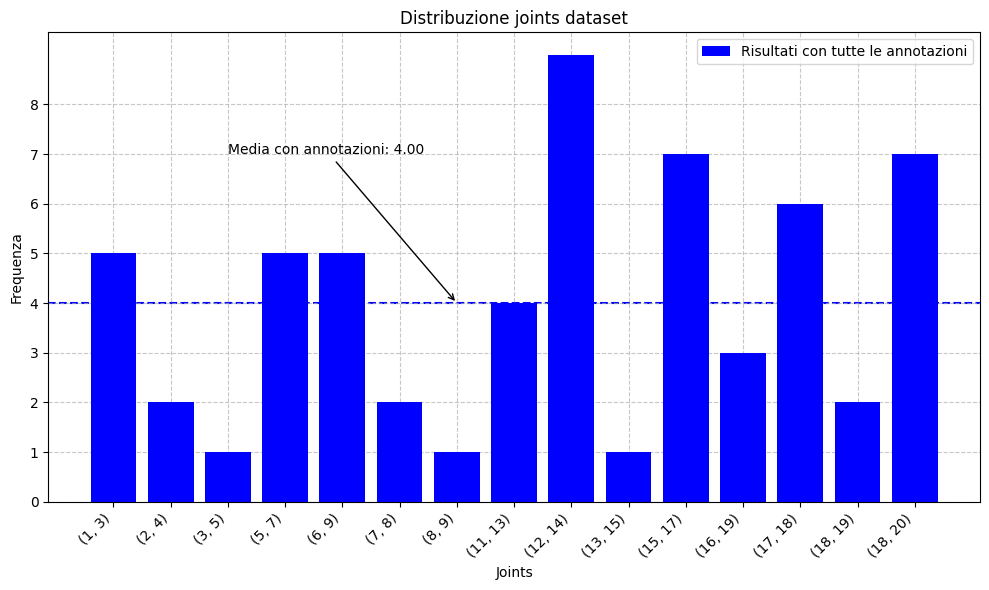

In [9]:
import matplotlib.pyplot as plt
from math import floor

labels2 = list(results.keys())
x_labels = list(sorted(list(set(labels2))))

y_values = [results[label] for label in x_labels ]

average = sum(y_values) / len(y_values)

#for i,value in reversed(list(enumerate(y_values))):
#    if value < floor(average):
#        x_labels.pop(i)
#        y_values.pop(i)

#average = sum(y_values)/len(y_values)

plt.figure(figsize=(10, 6))
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(average, color='blue', linestyle='--', zorder=0)
plt.bar(range(0,len(x_labels)), y_values, color='blue', label='Risultati con tutte le annotazioni')
plt.xticks(range(0,len(x_labels)),x_labels,rotation=45, ha='right')
plt.yticks(range(0,max(y_values)))
plt.xlabel('Joints')
plt.ylabel('Frequenza')
plt.title('Distribuzione joints dataset')

plt.annotate(f'Media con annotazioni: {average:.2f}', xy=(6, average), xytext=(2,average+3),
             arrowprops=dict(facecolor='blue', arrowstyle='->'), color='black')

plt.gca().set_axisbelow(True)
plt.legend()
plt.tight_layout()

plt.show()

## Machine Learning

### Question 1: "To be edge or not to be edge? That is the question"

#### Simple

In [10]:
import os
import pandas as pd
from math import floor
from tqdm.notebook import tqdm 
import time
from collections import deque
from sklearn.ensemble import RandomForestClassifier

ANNOTATIONS_PATH = 'data'
dataset = pd.read_csv(os.path.join(ANNOTATIONS_PATH,'Dataset.csv'))

dataset = dataset.sample(frac=1,random_state=42).reset_index(drop=True)
if not 'y_true' in globals() and not 'y_true' in locals():
    y_true = []
    y_pred = []
else:
    print("Model already present")
num_classes = 1#len(dataset['OoM'].value_counts())*( (-1*len(y_true)!=0) + len(y_true)==0)
outer_bar = tqdm(total=num_classes,desc="Full process progression: ")
rf = RandomForestClassifier()

for class_considered in range(num_classes):
    y_class_true = []
    y_class_pred = []
    target_label = list(dataset['OoM'].value_counts().index)[class_considered]

    question = 'Is '+str(ord_to_OoM[int(target_label)])+'?'
    dataset[question] = dataset['OoM'] == target_label
    labels = np.array(dataset[question].astype(int))

    features = np.array(dataset.drop('OoM',axis=1).drop(question,axis=1))


    # Create an empty FIFO queue
    training_queue = deque()

    # Add elements to the queue
    for i in range(len(labels)):
        training_queue.append(i)

    testing_queue = deque()

    num_sample_testing = 1
    num_epochs = floor(len(labels)/num_sample_testing)
    inner_bar = tqdm(total=num_epochs, desc=f"Processing class {ord_to_OoM[int(target_label)]} ",leave=False)

    for i in range(num_epochs):
        mask = np.ones(len(labels),dtype=bool)
        for j in range(num_sample_testing):
            test_indx = training_queue.popleft()
            mask[test_indx] = False
            testing_queue.append(test_indx)
        train_features = features[mask]
        train_labels = labels[mask]

        # Train the model on training data
        rf.fit(train_features, train_labels)

        test_features = features[np.logical_not(mask)]
        test_labels = labels[np.logical_not(mask)]
        # Use the forest's predict method on the test data
        RF_prediction = rf.predict(test_features)
        for j in range(num_sample_testing):
            if len(RF_prediction.shape) == 1:
                RF_prediction = RF_prediction[:,np.newaxis]
                test_labels = test_labels[:,np.newaxis]
            y_class_true.append(int(test_labels[j,:].all()))
            y_class_pred.append(int((RF_prediction[j,:] > 0.5).all()))
            training_queue.append(testing_queue.popleft())
        time.sleep(0.01)
        inner_bar.update(1)
    inner_bar.close()
    
    y_true.append(y_class_true)
    y_pred.append(y_class_pred)
    time.sleep(0.01)
    outer_bar.update(1)
    
outer_bar.close()

Full process progression:   0%|          | 0/1 [00:00<?, ?it/s]

Processing class (12, 14) :   0%|          | 0/60 [00:00<?, ?it/s]

#### Balanced class weight & RandomSearch hyperparam tuning & sensitivity as score

In [11]:
import numpy as np
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix, make_scorer, recall_score
from tqdm.notebook import tqdm

target_label = list(dataset['OoM'].value_counts().index)[0]
question = 'Is '+str(ord_to_OoM[int(target_label)])+'?'
print(question)
dataset[question] = dataset['OoM'] == target_label
labels = np.array(dataset[question].astype(int))
features = np.array(dataset.drop('OoM',axis=1).drop(question,axis=1))
n = len(labels)
y_class_true = []
y_class_pred = []
rf = RandomForestClassifier(class_weight='balanced',n_jobs=-1)

# Use specificity as the scoring metric
def sensitivity_scoring(y_true, y_pred):
    conf_matrix = {"TP":0,"TN":0,"FP":0,"FN":0}
    for y_t,y_p in zip(y_true,y_pred):
        conf_matrix[("T" if y_t==y_p else "F") + ("P" if y_t==1 else "N")] += 1
    TP = conf_matrix['TP']
    FN = conf_matrix['FN']
    if TP + FN == 0:
        return 0
    return TP / (TP + FN)


# Define a parameter distribution to sample from
param_dist = {
    'n_estimators': randint(10, 100),
    'max_depth': randint(2, 10),
    'min_samples_split': randint(2, 5)
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, scoring=make_scorer(sensitivity_scoring))

# Fit the model with different hyperparameters
random_search.fit(features[:-10], labels[:-10])

# Get the best hyperparameters and the best model
rnd_best_params = random_search.best_params_
print(rnd_best_params)


# Define a parameter grid to search over
#param_grid = {
#    'n_estimators': list(range(10,200,10)),
#    'max_depth': list(range(2,10))
#}

# Create a GridSearchCV object
#grid_search = GridSearchCV( estimator=rf, param_grid=param_grid, cv=5, scoring=make_scorer(specificity_scoring))

# Fit the model with different hyperparameters
#grid_search.fit(features,labels)#np.delete(features,slice(len(features)-5,len(features)-1),axis=0),np.delete(labels,slice(len(labels)-5,len(labels)-1),axis=0))

# Get the best hyperparameters and the best model
#best_params = grid_search.best_params_
#print(grid_search.best_score_)

rf = RandomForestClassifier(**rnd_best_params)
best_rf = random_search.best_estimator_

#print(best_params)

for i in tqdm(range(n)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)

    # Train the model on training data
    rf.fit(train_features, train_labels)
    
    test_features = features[i].reshape(1, -1)
    test_labels = labels[i]
    rf_prediction = rf.predict(test_features)
    
    y_class_true.append(test_labels)
    y_class_pred.append(rf_prediction[0])

# Print confusion matrix and accuracy
print("Confusion Matrix:")
print(confusion_matrix(y_class_true, y_class_pred),'\n',recall_score(y_class_true,y_class_pred))


Is (12, 14)?
{'max_depth': 6, 'min_samples_split': 3, 'n_estimators': 51}


  0%|          | 0/60 [00:00<?, ?it/s]

Confusion Matrix:
[[50  1]
 [ 8  1]] 
 0.1111111111111111


#### Balanced class weight

In [12]:
rf = RandomForestClassifier(class_weight='balanced',n_jobs=-1)
n = len(labels)
y_class_true = []
y_class_pred = []

for i in tqdm(range(n)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)

    # Train the model on training data
    rf.fit(train_features, train_labels)
    
    test_features = features[i].reshape(1, -1)
    test_labels = labels[i]
    rf_prediction = rf.predict(test_features)
    
    y_class_true.append(test_labels)
    y_class_pred.append(rf_prediction[0])
    
y_class_true = np.array(y_class_true)
y_class_pred = np.array(y_class_pred)
print(confusion_matrix(y_class_true,y_class_pred))

  0%|          | 0/60 [00:00<?, ?it/s]

[[51  0]
 [ 9  0]]


#### Oversampling

In [13]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


rf = RandomForestClassifier(n_jobs=-1)
ros = RandomOverSampler()
n = len(labels)
y_class_true = []
y_class_pred = []

for i in tqdm(range(n)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)
    train_features_resampled, train_labels_resampled = ros.fit_resample(train_features, train_labels)

    # Train the model on training data
    rf.fit(train_features_resampled, train_labels_resampled)
    
    test_features = features[i].reshape(1, -1)
    test_labels = labels[i]
    rf_prediction = rf.predict(test_features)
    
    y_class_true.append(test_labels)
    y_class_pred.append(rf_prediction[0])

y_class_true = np.array(y_class_true)
y_class_pred = np.array(y_class_pred)
print(confusion_matrix(y_class_true,y_class_pred))

  0%|          | 0/60 [00:00<?, ?it/s]

[[50  1]
 [ 8  1]]


#### Undersampling

In [14]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


rf = RandomForestClassifier(n_jobs=-1)
ruc = RandomUnderSampler()
n = len(labels)
y_class_true = []
y_class_pred = []

for i in tqdm(range(n)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)
    train_features_resampled, train_labels_resampled = ruc.fit_resample(train_features, train_labels)

    # Train the model on training data
    rf.fit(train_features_resampled, train_labels_resampled)
    
    test_features = features[i].reshape(1, -1)
    test_labels = labels[i]
    rf_prediction = rf.predict(test_features)
    
    y_class_true.append(test_labels)
    y_class_pred.append(rf_prediction[0])

y_class_true = np.array(y_class_true)
y_class_pred = np.array(y_class_pred)
print(confusion_matrix(y_class_true,y_class_pred))
cm = confusion_matrix(y_class_true,y_class_pred)

  0%|          | 0/60 [00:00<?, ?it/s]

[[39 12]
 [ 3  6]]


#### SMOTE

In [15]:
from imblearn.over_sampling import SMOTE

# Create an instance of SMOTE
smote = SMOTE(sampling_strategy='auto')

n = len(labels)
y_class_true = []
y_class_pred = []

for i in tqdm(range(n)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)
    train_features_resampled, train_labels_resampled = smote.fit_resample(train_features, train_labels)

    # Train the model on training data
    rf.fit(train_features_resampled, train_labels_resampled)
    
    test_features = features[i].reshape(1, -1)
    test_labels = labels[i]
    rf_prediction = rf.predict(test_features)
    
    y_class_true.append(test_labels)
    y_class_pred.append(rf_prediction[0])

y_class_true = np.array(y_class_true)
y_class_pred = np.array(y_class_pred)
print(confusion_matrix(y_class_true,y_class_pred))
cm = confusion_matrix(y_class_true,y_class_pred)

  0%|          | 0/60 [00:00<?, ?it/s]

[[49  2]
 [ 6  3]]


#### Borderline-SMOTE

In [16]:
from imblearn.over_sampling import BorderlineSMOTE

rf = RandomForestClassifier(n_jobs=-1)
# Create an instance of Borderline-SMOTE
borderline_smote = BorderlineSMOTE(sampling_strategy='auto')
n = len(labels)
y_class_true = []
y_class_pred = []

for i in tqdm(range(n)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)
    train_features_resampled, train_labels_resampled = borderline_smote.fit_resample(train_features, train_labels)

    # Train the model on training data
    rf.fit(train_features_resampled, train_labels_resampled)
    
    test_features = features[i].reshape(1, -1)
    test_labels = labels[i]
    rf_prediction = rf.predict(test_features)
    
    y_class_true.append(test_labels)
    y_class_pred.append(rf_prediction[0])

y_class_true = np.array(y_class_true)
y_class_pred = np.array(y_class_pred)
print(confusion_matrix(y_class_true,y_class_pred))
cm = confusion_matrix(y_class_true,y_class_pred)


  0%|          | 0/60 [00:00<?, ?it/s]

[[51  0]
 [ 6  3]]


#### Adasyn

In [17]:
from imblearn.over_sampling import ADASYN

rf = RandomForestClassifier(n_jobs=-1)
# Create an instance of adasyn
adasyn = ADASYN(sampling_strategy='auto')
n = len(labels)
y_class_true = []
y_class_pred = []

for i in tqdm(range(n)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)
    train_features_resampled, train_labels_resampled = adasyn.fit_resample(train_features, train_labels)

    # Train the model on training data
    rf.fit(train_features_resampled, train_labels_resampled)
    
    test_features = features[i].reshape(1, -1)
    test_labels = labels[i]
    rf_prediction = rf.predict(test_features)
    
    y_class_true.append(test_labels)
    y_class_pred.append(rf_prediction[0])

y_class_true = np.array(y_class_true)
y_class_pred = np.array(y_class_pred)
print(confusion_matrix(y_class_true,y_class_pred))
cm = confusion_matrix(y_class_true,y_class_pred)


  0%|          | 0/60 [00:00<?, ?it/s]

[[51  0]
 [ 5  4]]


#### Metrics
- Confusion Matrix

| Actual \ Predicted | True | False |
|---------|-----------|------------|
| True |   TP      |     FN     |
| False |   FP      |     TN     |

- Precision:
 TP / (TP + FP)

- Specificity:
 TN / (TN + FP)

- Recall:
 TP / (TP + FN)

- F1 Score:
 2 * Precision * Recall / (Precision + Recall)


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def score_calculator(y_true,y_pred,overall=True,normalize='all'):
    '''
    Calculates confusion matrix, precision, recall, f1
    '''
    if not overall:
        confusion_matrix = []
        for i in range(len(y_true)):
            confusion_matrix += [{"TP":0,"TN":0,"FP":0,"FN":0}]
    else:
        confusion_matrix = {"TP":0,"TN":0,"FP":0,"FN":0}
    for label in range(len(y_true)):
        for y_t,y_p in zip(y_true[label],y_pred[label]):
            if not overall:
                confusion_matrix[label][("T" if y_t==y_p else "F") + ("P" if y_t==1 else "N")] += 1   
            else: 
               confusion_matrix[("T" if y_t==y_p else "F") + ("P" if y_t==1 else "N")] += 1
    if not overall:
        temp = []
        for label in range(len(y_true)):
            temp.append(np.array([[confusion_matrix[label]["TN"],confusion_matrix[label]["FN"]],[confusion_matrix[label]["FP"],confusion_matrix[label]["TP"]]], dtype=int if normalize is None else float))
        confusion_matrix = np.array(temp)
    else:
        confusion_matrix = np.array([[confusion_matrix["TN"],confusion_matrix["FN"]],[confusion_matrix["FP"],confusion_matrix["TP"]]], dtype=int if normalize is None else float)
    if normalize=='all':
        if not overall:
            for label in range(len(y_true)):
                confusion_matrix[label] /= np.sum(confusion_matrix[label],axis=None)
        else:
            confusion_matrix /= np.sum(confusion_matrix, axis=None)
    if not overall:
        precision = []
        recall = []
        f1 = []
        with np.errstate(divide='ignore', invalid='ignore'):
            for label in range(len(y_true)):
                precision.append(confusion_matrix[label][0,0]/(confusion_matrix[label][0,0]+confusion_matrix[label][1,0]))
                recall.append(confusion_matrix[label][0,0]/(confusion_matrix[label][0,0]+confusion_matrix[label][0,1]))
                f1.append(2*precision[-1]*recall[-1]/(precision[-1]+recall[-1]))
    else:
        precision = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
        recall = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])
        f1 = 2*precision*recall / (precision+recall)
    return  confusion_matrix,precision,recall,f1

cm, precision, recall, f1 = score_calculator(y_true,y_pred,overall=False,normalize=None)
print(confusion_matrix(y_true[0],y_pred[0]))
print("Precision per class: ", precision )
print("Recall per class: ",recall )
print("F1 per class: ",f1 )
cm = np.hstack(cm[:])
plt.figure(figsize=(36, 3))
sns.set(font_scale=1.5)  # Adjust the font size for better readability
x_labels = [f"Is Class {ord_to_OoM[int(label)]}" if i % 2 == 0 else "Is Not Class" for i,label in enumerate(list(dataset['OoM'].value_counts().index)*2)]
sns.heatmap(cm, annot=True, cmap='Blues',cbar=False, xticklabels=x_labels,yticklabels=["|Is Class|",'|Is Not Class|'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for all classes')
plt.show()

cm, precision, recall, f1 = score_calculator(y_true,y_pred)
print("Precision: ", precision )
print("Recall: ",recall )
print("F1: ",f1 )

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better readability
sns.heatmap(cm, annot=True, cmap='Blues',cbar=False, xticklabels=["Is Not class","Is class"],yticklabels=["|Is Class|",'|Is Not Class|'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for all classes')
plt.show()

TypeError: 'numpy.int64' object is not iterable

### Question 2: "Is it the leg day?"

In [ ]:
# right leg, left leg, right arm, left arm, head 
ord_edge_groups = {0: [0,2,3,5], 1:[1,4,6], 2:[7,9,10,12], 3:[8,11,13], 4:[14]}
group_names = {0: "right leg", 1: "left leg", 2:"right arm", 3:"left arm", 4:"head"}
rev_ord_edge_groups = {value: key for key, values in ord_edge_groups.items() for value in values}

labels = np.array(dataset['OoM'].apply(lambda label: rev_ord_edge_groups[label]))
print(labels)
y_true = []
y_pred = []


[2 4 1 2 0 4 1 2 3 1 2 1 0 3 3 2 0 0 1 3 2 4 0 2 3 2 0 1 3 4 3 2 3 0 3 1 2
 0 0 3 2 4 3 0 2 0 0 4 2 3 2 2 2 3 2 2 4 3 0 1]


### SVC

In [277]:
from sklearn.svm import SVC

# Create separate SVM classifiers for each label
svm_classifiers = { j : SVC(kernel='poly',probability=True, random_state=42) for j in range(train_labels.shape[1]) if any(train_labels[:,j])}
[classifier.fit(train_features, train_labels[:,j]) for j,classifier in svm_classifiers.items()]

# Predict labels on the test data for each classifier
predictions_partial = np.column_stack([svm_classifiers[indx].predict(test_features) for indx in svm_classifiers.keys()])
SVM_predictions = np.zeros(test_labels.shape,dtype=int)
for i in range(predictions_partial.shape[1]):
    SVM_predictions[:,list(svm_classifiers.keys())[i]] = predictions_partial[:,i]
print(SVM_predictions)
print(svm_classifiers[9].predict_proba(test_features), svm_classifiers[9].predict(test_features))

print((SVM_predictions*test_labels).sum()/len(SVM_predictions))

[[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[0.91383818 0.08616182]
 [0.89642348 0.10357652]
 [0.89565488 0.10434512]
 [0.87809684 0.12190316]
 [0.88036448 0.11963552]
 [0.91557783 0.08442217]
 [0.91581105 0.08418895]
 [0.8432239  0.1567761 ]
 [0.92079516 0.07920484]
 [0.91151324 0.08848676]
 [0.90570939 0.09429061]
 [0.89819709 0.10180291]
 [0.87122814 0.12877186]
 [0.90812537 0.09187463]
 [0.90663124 0.09336876]] [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
0.06666666666666667


### Neural Networks

1/1 [==============================] - 0s 52ms/step


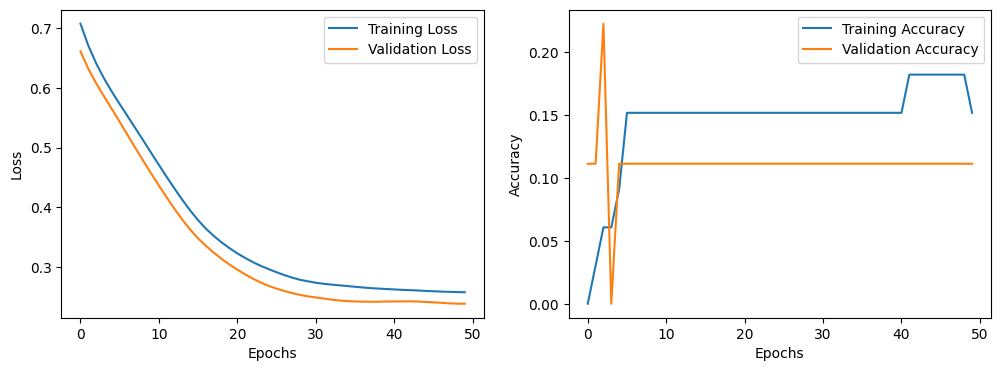

0.0984400488436222


In [278]:
import tensorflow as tf

tf.keras.utils.set_random_seed(seed=42)

# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(train_features.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),  # You can adjust the number of neurons
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(train_labels.shape[1], activation='sigmoid')  # Sigmoid activation for multi-label classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary cross-entropy loss for multi-label classification
              metrics=['accuracy'])
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=41)

# Train the model
epochs = 50  # Number of epochs to avoid overfitting
history = model.fit(X_train, y_train, epochs=epochs, verbose=0,validation_data=(X_val,y_val))
NN_predictions = model.predict(test_features)

# Plot training loss and accuracy
plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


print((NN_predictions*test_labels).sum()/len(NN_predictions))

### KNeighbours

In [279]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Create a multi-label classifier
classifier = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=1))

# Train the classifier
classifier.fit(train_features, train_labels)

# Make predictions on the test set
KNeighbors_predictions = classifier.predict(test_features)

### Logistic Regression

In [280]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

classifier = MultiOutputClassifier(LogisticRegression(penalty=None,random_state=42))

#classifier.fit(train_features, train_labels)

#LR_predictions = classifier.predict(test_features)

### Random Forest

In [281]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

rf = RandomForestRegressor(n_estimators = 400, random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels)

# Use the forest's predict method on the test data
RF_predictions = rf.predict(test_features)
print((RF_predictions*test_labels).sum()/len(RF_predictions))

0.09716666666666667


In [282]:
# Import tools needed for visualization
#%pip install pydot
from sklearn.tree import export_graphviz
from IPython.display import display

# Pull out one tree from the forest
tree = rf.estimators_[5]

# Import tools needed for visualization
from sklearn.tree import export_graphviz

# Pull out one tree from the forest
tree = rf.estimators_[5]

# Export the image to a dot file
dot_code = export_graphviz(tree, feature_names = dataset.columns[:-1], rounded = True, precision = 1)

dot_code = dot_code.replace(']\n[','],[')

import graphviz
graph = graphviz.Source(dot_code, format="png")

In [283]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(dataset.columns[:-1], importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
for pair in feature_importances[:10]:
    if pair[1] >= 0.01:
        print('Variable: {:20} Importance: {}'.format(*pair))  

Variable: mad_right_hand       Importance: 0.05
Variable: mean_left_hip        Importance: 0.03
Variable: sma_left_hip         Importance: 0.03
Variable: mean_right_hip       Importance: 0.02
Variable: var_right_foot       Importance: 0.02
Variable: var_right_wrist      Importance: 0.02
Variable: var_right_elbow      Importance: 0.02
Variable: mad_hip_central      Importance: 0.02
Variable: mad_right_hip        Importance: 0.02
Variable: mad_left_hand        Importance: 0.02


In [284]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Extract the two most important features
important_indices = [list(dataset.columns[:-1]).index(feature_importances[0][0])]#, list(dataset.columns[:-1]).index(feature_importances[1][0])]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, train_labels)
# Make predictions and determine the error
RF_BF_predictions = rf_most_important.predict(test_important)

### Reduced markers
![edges](../resources/reducedMarkersForML.png) ![joints](../resources/reducedMarkersJointsForML.png)

In [300]:
import numpy as np
from collections import deque
import pandas as pd


jointsFromReduced = [1, 3, 5, 7, 2, 4, 6, 8, 9, 9, 9,10,10,16,11,13,15,12,14]
jointsToReduced =   [3, 5, 7, 8, 4, 6, 8, 9,10,16,17,16,17,17,13,15,17,14,16]
#                 1     2     3     4     5     6     7     8     9      10      11      12      13      14      15       16      17
edgesToNodes = [(1,3),(2,4),(3,5),(4,6),(5,7),(6,8),(7,8),(8,9),(9,10),(10,18),(11,13),(12,14),(13,15),(14,16),(15,17),(10,16),(10,17)]
allNodes = set(jointsFromReduced).union(set(jointsToReduced))

jointsFromReduced = list(map(lambda x: x-1,jointsFromReduced))
jointsToReduced = list(map(lambda x: x-1,jointsToReduced))
edges = np.array(list(zip(jointsFromReduced,jointsToReduced))+list(zip(jointsToReduced,jointsFromReduced)))

adjacencyMatrix = np.zeros((len(allNodes),len(allNodes)),dtype=int)
adjacencyMatrix[edges[:,0],edges[:,1]] = 1

# Number of nodes in the graph
num_nodes = len(adjacencyMatrix)

# Function to calculate distances using BFS
def calculate_distances(start_node):
    distances = np.full(num_nodes, -1)  # Initialize distances to -1 (indicating unreachable)
    distances[start_node] = 0  # The distance to itself is 0
    queue = deque([start_node])

    while queue:
        node = queue.popleft()
        for neighbor in range(num_nodes):
            if adjacencyMatrix[node][neighbor] == 1 and distances[neighbor] == -1:
                distances[neighbor] = distances[node] + 1
                queue.append(neighbor)
    
    return distances

# Calculate distances for every node
all_distances = []
for node in range(num_nodes):
    distances = calculate_distances(node)
    all_distances.append(distances)
gain = 1/(np.vstack(all_distances)+1)
#gain[gain >= 0.6] = 1.
#gain[np.logical_and(0.49 <= gain,gain <= 0.51)] = 0.5
#gain[gain >= 0.5] = 1.
#gain[gain < 0.5] = 0.
gain_table = pd.DataFrame(gain, index=[str(value) for value in edgesToNodes], columns=[str(value) for value in edgesToNodes])

gain_table

,"(1, 3)","(2, 4)","(3, 5)","(4, 6)","(5, 7)","(6, 8)","(7, 8)","(8, 9)","(9, 10)","(10, 18)","(11, 13)","(12, 14)","(13, 15)","(14, 16)","(15, 17)","(10, 16)","(10, 17)"
"(1, 3)",1.000000,0.125000,0.500000,0.142857,0.333333,0.166667,0.250000,0.200000,0.166667,0.142857,0.100000,0.111111,0.111111,0.125000,0.125000,0.142857,0.142857
"(2, 4)",0.125000,1.000000,0.142857,0.500000,0.166667,0.333333,0.200000,0.250000,0.200000,0.166667,0.111111,0.125000,0.125000,0.142857,0.142857,0.166667,0.166667
"(3, 5)",0.500000,0.142857,1.000000,0.166667,0.500000,0.200000,0.333333,0.250000,0.200000,0.166667,0.111111,0.125000,0.125000,0.142857,0.142857,0.166667,0.166667
"(4, 6)",0.142857,0.500000,0.166667,1.000000,0.200000,0.500000,0.250000,0.333333,0.250000,0.200000,0.125000,0.142857,0.142857,0.166667,0.166667,0.200000,0.200000
"(5, 7)",0.333333,0.166667,0.500000,0.200000,1.000000,0.250000,0.500000,0.333333,0.250000,0.200000,0.125000,0.142857,0.142857,0.166667,0.166667,0.200000,0.200000
"(6, 8)",0.166667,0.333333,0.200000,0.500000,0.250000,1.000000,0.333333,0.500000,0.333333,0.250000,0.142857,0.166667,0.166667,0.200000,0.200000,0.250000,0.250000
"(7, 8)",0.250000,0.200000,0.333333,0.250000,0.500000,0.333333,1.000000,0.500000,0.333333,0.250000,0.142857,0.166667,0.166667,0.200000,0.200000,0.250000,0.250000
"(8, 9)",0.200000,0.250000,0.250000,0.333333,0.333333,0.500000,0.500000,1.000000,0.500000,0.333333,0.166667,0.200000,0.200000,0.250000,0.250000,0.333333,0.333333
"(9, 10)",0.166667,0.200000,0.200000,0.250000,0.250000,0.333333,0.333333,0.500000,1.000000,0.500000,0.200000,0.250000,0.250000,0.333333,0.333333,0.500000,0.500000
"(10, 18)",0.142857,0.166667,0.166667,0.200000,0.200000,0.250000,0.250000,0.333333,0.500000,1.000000,0.200000,0.250000,0.250000,0.333333,0.333333,0.500000,0.500000


In [301]:
def calculate_scoring(predictions,test_labels=test_labels,gain=gain):
    n_test = len(test_labels)
    score = 0.
    baseline = 0.
    random_scoring = 0.
    rng = np.random.default_rng(seed=42)
    for i in range(n_test):
        score += (predictions[i]*gain[:,np.array(test_labels[i]).astype(bool)].max(axis=1)).sum()
        baseline += (np.ones(len(predictions[i]))/len(predictions[i])*gain[:,np.array(test_labels[i]).astype(bool)].max(axis=1)).sum()
        rand_mat = rng.random(len(predictions[i]))
        random_scoring += (rand_mat/rand_mat.sum()*gain[:,np.array(test_labels[i]).astype(bool)].max(axis=1)).sum()
    return baseline/n_test, random_scoring/n_test, score/n_test
print("Baseline (equal distribution): \t\t\t",calculate_scoring(RF_predictions)[0],'\n')
print("Random: \t\t\t\t\t",calculate_scoring(RF_predictions)[1],'\n')
print("SVM: \t\t\t\t\t\t",calculate_scoring(SVM_predictions)[2],'\n')
print("Neural Network: \t\t\t\t",calculate_scoring(NN_predictions)[2],'\n')
print("Random Forest: \t\t\t\t\t",calculate_scoring(RF_predictions)[2],'\n')
print(f"Random Forest based only on '{feature_importances[0][0]}': \t",calculate_scoring(RF_BF_predictions)[2],'\n')
print("KNeighbours: \t\t\t\t\t",calculate_scoring(KNeighbors_predictions)[2],'\n')
#print("LogisticRession: \t\t\t\t",calculate_scoring(LR_predictions)[2],'\n')

Baseline (equal distribution): 			 0.3093028322440087 

Random: 					 0.30351138146800083 

SVM: 						 0.1934126984126984 

Neural Network: 				 0.4522221332194195 

Random Forest: 					 0.4225855158730159 

Random Forest based only on 'mad_right_hand': 	 0.4305111111111111 

KNeighbours: 					 0.6134920634920635 



In [287]:
def accuracy_on_point_joint(predictions):
    if predictions is None:
        rng = np.random.default_rng(seed=42)
        rand_mat = rng.random(test_labels.shape)
        rand_mat = rand_mat/np.sum(rand_mat,axis=1)[:,np.newaxis]
        return (rand_mat*test_labels).sum()/len(test_labels)
    return (predictions*test_labels).sum()/len(test_labels)

print("Baseline (equal distribution): \t\t\t",accuracy_on_point_joint(np.ones(test_labels.shape)/test_labels.shape[1]),'\n')
print("Random: \t\t\t\t\t",accuracy_on_point_joint(None),'\n')
print("SVM: \t\t\t\t\t\t",accuracy_on_point_joint(SVM_predictions),'\n')
print("Neural Network: \t\t\t\t",accuracy_on_point_joint(NN_predictions),'\n')
print("Random Forest: \t\t\t\t\t",accuracy_on_point_joint(RF_predictions),'\n')
print(f"Random Forest based only on '{feature_importances[0][0]}': \t",accuracy_on_point_joint(RF_BF_predictions),'\n')
print("KNeighbours: \t\t\t\t\t",accuracy_on_point_joint(KNeighbors_predictions),'\n')
#print("LogisticRession: \t\t\t\t",accuracy_on_point_joint(LR_predictions),'\n')

Baseline (equal distribution): 			 0.07058823529411763 

Random: 					 0.06292047063071406 

SVM: 						 0.06666666666666667 

Neural Network: 				 0.0984400488436222 

Random Forest: 					 0.09716666666666667 

Random Forest based only on 'mad_right_hand': 	 0.1016 

KNeighbours: 					 0.2 



In [167]:
from sklearn.metrics import roc_curve, roc_auc_score

KNeighbors_predictions

array([[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [111]:
# Suppress the divide by zero warning temporarily
np.seterr(divide='ignore', invalid='ignore')

# Calculate MAPE
def calculate_mape(actual, predicted):
    epsilon = 1e-10  # Small epsilon value to avoid division by zero
    abs_percentage_error = np.abs((actual - predicted) / (actual + epsilon))
    mape = np.mean(abs_percentage_error) * 100
    return mape

# Calculate MAPE, handling division by zero
mape = calculate_mape(test_labels, predictions)

# Print the MAPE
print("MAPE:", mape)

errors = abs(predictions - test_labels)# Print out the mean absolute error (mae)
#print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
#print(test_labels)
print(1-np.mean((errors)/(test_labels)))

# Calculate mean absolute percentage error (MAPE)
mape = (errors / test_labels)# Calculate and display accuracy
# Check for and handle division by zero
print(mape)
mape[np.isinf(mape)] = 1.  # Replace inf values with 0
#mape[np.isnan(mape)] = 0.

accuracy = 1 - np.mean(mape)
print('Accuracy:', round(accuracy*100, 2), '%.')

ValueError: continuous-multioutput is not supported

## Derivatives

In [88]:
import numpy as np
import pandas as pd

def group_table_by_joints(table:pd.DataFrame):
    columns = [col.replace('_X','') for col in list(table.columns)[::3]]
    result = pd.DataFrame(columns=columns)
    for j in range(0,table.shape[1],3):
        lst = []
        for i in range(table.shape[0]):
            lst.append(table.iloc[i,j:j+3].values)
        result[columns[int(j/3)]] = lst
    return result

def compute_derivatives(posTable:pd.DataFrame,timeCol,which:set={'speed'}):
    out = []
    if 'speed' in which:
        velocityTable = pd.DataFrame(np.gradient(posTable,timeCol,axis=0),columns=[f'{c}' for c in posTable.columns])
        out.append(velocityTable)
    if 'acceleration' in which:
        accelerationTable = pd.DataFrame(np.gradient(velocityTable,timeCol,axis=0),columns=[f'{c}' for c in velocityTable.columns])
        out.append(accelerationTable)
    if len(out) == 1:
        return out[0]
    return out

def compute_angular_momentum(posTables,timeCol):
    m_lfoot = 0.0145;m_rfoot = 0.0145;m_lank = 0.0465;m_rank = 0.0465
    m_lknee = 0.1;m_rknee = 0.1;m_lhip = 0.1;m_hipc = 0.139;m_rhip = 0.1
    m_spine = 0.216;m_lhand = 0.006;m_rhand = 0.006;m_lwrist = 0.016;m_rwrist = 0.016
    m_lelb = 0.028;m_relb = 0.028;m_lsho = 0.0158;m_shoc = 0.081;m_rsho = 0.0158;m_head = 0.081

    mass = [m_lfoot, m_rfoot, m_lank, m_rank, m_lknee,  m_rknee, m_lhip, m_hipc, m_rhip, m_spine, m_lhand, m_rhand, m_lwrist, m_rwrist, m_lelb, m_relb, m_lsho, m_shoc, m_rsho, m_head]
    
    posTableX, posTableY, posTableZ = posTables
    posTableX:pd.DataFrame;posTableY:pd.DataFrame;posTableZ:pd.DataFrame

    centerOfMassX = posTableX.dot(mass).div(sum(mass))
    centerOfMassY = posTableY.dot(mass).div(sum(mass))
    centerOfMassZ = posTableZ.dot(mass).div(sum(mass))

    radiusQX = posTableX.sub(centerOfMassX,axis=0)
    radiusQY = posTableY.sub(centerOfMassY,axis=0)
    radiusQZ = posTableZ.sub(centerOfMassZ,axis=0)

    def merge_tables(xTable,yTable,zTable):
        mergedTable = pd.DataFrame()
        for j in range(xTable.shape[1]):
            mergedTable = pd.concat([mergedTable,xTable.iloc[:,j],yTable.iloc[:,j],zTable.iloc[:,j]],axis=1)
        return mergedTable
    
    radiusQTable = merge_tables(radiusQX,radiusQY,radiusQZ)
    p = compute_derivatives(merge_tables(posTableX,posTableY,posTableZ),timeCol).mul(np.repeat(mass,3))

    def split_table(table,into="xyz"):
        if into == "xyz":
            return table.iloc[:,::3],table.iloc[:,1::3],table.iloc[:,2::3]
        elif into == "points":
            return [table.iloc[:,j:j+3] for j in range(0,table.shape[1],3)]
        
    p = [point.to_numpy() for point in split_table(p,into="points")]
    r = [point.to_numpy() for point in split_table(radiusQTable, into="points")]
    l = np.cross(p,r)

    angularMomentumTable = radiusQTable*0
    for j,point in enumerate(l):
        for i in range(len(point)):
            angularMomentumTable.iloc[i,3*j:3*j+3] = point[i]
    return angularMomentumTable

## Similarity functions 

In [89]:
from scipy.spatial.distance import cosine
def compute_cosine_similarity_on_joints(featureTable,normalized:None or int=None):
    jointsFrom = [1, 3, 5, 7, 2, 4, 6, 8, 8,10,11,13,15,17,12,14,16,18,18]
    jointsTo =   [3, 5, 7, 8, 4, 6, 9, 9,10,18,13,15,17,18,14,16,19,19,20]

    jointsFrom = list(map(lambda x: x-1,jointsFrom))
    jointsTo = list(map(lambda x: x-1,jointsTo))

    cosineSim = pd.DataFrame()
    columnNames = list(featureTable.columns)
    for jointFrom,jointTo in zip(jointsFrom,jointsTo):
        cosineSim[columnNames[jointFrom]+" - "+columnNames[jointTo]] = featureTable.apply(lambda row: 2 - cosine(row[columnNames[jointFrom]],row[columnNames[jointTo]]),axis=1)
    return cosineSim if normalized is None else cosineSim.div(cosineSim.max(axis=1))*normalized

from numpy.linalg import norm
def compute_inverse_difference_on_joints(featureTable):
    jointsFrom = [1, 3, 5, 7, 2, 4, 6, 9, 8,10,11,13,15,17,12,14,16,19,18]
    jointsTo =   [3, 5, 7, 8, 4, 6, 9, 8,10,18,13,15,17,18,14,16,19,18,20]
    jointsFrom = list(map(lambda x: x-1,jointsFrom))
    jointsTo = list(map(lambda x: x-1,jointsTo))

    invDiffModulus = pd.DataFrame()
    eps = 10**(-9)  # To avoid division by 0
    columnNames = list(featureTable.columns)
    for jointFrom,jointTo in zip(jointsFrom,jointsTo):
        invDiffModulus[columnNames[jointFrom]+" - "+columnNames[jointTo]] = featureTable.apply(lambda row: norm(row[columnNames[jointFrom]]-row[columnNames[jointTo]])+eps,axis=1)
    return 1 / invDiffModulus
    

def group_table_by_joints(table):
    columns = [col.replace('_X','') for col in list(table.columns)[::3]]
    result = pd.DataFrame(columns=columns)
    for j in range(0,table.shape[1],3):
        lst = []
        for i in range(table.shape[0]):
            lst.append(table.iloc[i,j:j+3].values)
        result[columns[int(j/3)]] = lst
    return result

## Optional functions for rotating, filtering, plotting

In [90]:
def filter_and_rotate_table(picked:int,posTable:pd.DataFrame):
    if 1 <= picked <= 10:
        posTableY = posTable.iloc[:,::3]
        posTableZ = posTable.iloc[:,1::3]
        posTableX = posTable.iloc[:,2::3]
    elif 11 <= picked <= 16:
        posTableX = posTable.iloc[:,::3]
        posTableZ = posTable.iloc[:,1::3]
        posTableY = posTable.iloc[:,2::3]
    elif (17 <= picked <= 20 and picked != 19) or picked >= 25:
        posTableY = posTable.iloc[:,::3]
        posTableX = posTable.iloc[:,1::3]
        posTableZ = posTable.iloc[:,2::3]
    else:
        posTableX = posTable.iloc[:,::3]
        posTableY = posTable.iloc[:,1::3]
        posTableZ = posTable.iloc[:,2::3]

    posTableX = posTableX.rename(columns=dict(zip(list(posTableX),[name.replace('Z','X').replace('Y','X') for name in list(posTableX)])))
    posTableY = posTableY.rename(columns=dict(zip(list(posTableY),[name.replace('Z','Y').replace('X','Y') for name in list(posTableY)])))
    posTableZ = posTableZ.rename(columns=dict(zip(list(posTableZ),[name.replace('X','Z').replace('Y','Z') for name in list(posTableZ)])))

    return (posTableX,posTableY,posTableZ)


from matplotlib import pyplot as plt
from matplotlib.widgets import Slider
import numpy as np

def draw_skeleton(posTable:tuple,picked:int):
    posTableX,posTableY,posTableZ = posTable
    posTableX:pd.DataFrame
    posTableY:pd.DataFrame
    posTableZ:pd.DataFrame
    plt.close("all")
    %matplotlib
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')


    minMax = np.zeros((2,3))
    minMax[0,:] = [posTableX.values.min(),posTableY.values.min(),posTableZ.values.min()]
    minMax[1,:] = [posTableX.values.max(),posTableY.values.max(),posTableZ.values.max()]

    print(minMax)

    # Set appropriate axis limits
    ax.set_xlim([minMax[0,0],minMax[1,0]])
    ax.set_ylim([minMax[0,1],minMax[1,1]])
    ax.set_zlim([minMax[0,2],minMax[1,2]])

    # Set the window title
    fig.canvas.manager.window.title("3D Movement\t(Scroll with mouse wheel)")

    # Set the initial time index
    time_index = 0

    # Function to update the plot based on the slider value
    def update_plot(val):
        ax.cla()  # Clear the previous plot

        # Filter the data based on the current time index
        filteredX = posTableX.iloc[val]
        filteredY = posTableY.iloc[val]
        filteredZ = posTableZ.iloc[val]

        ax.scatter(filteredX,filteredY,filteredZ)

        ax.set_xlim([minMax[0,0],minMax[1,0]])
        ax.set_ylim([minMax[0,1],minMax[1,1]])
        ax.set_zlim([minMax[0,2],minMax[1,2]])

        ax.set_xlabel('X', fontsize=12)
        ax.set_ylabel('Y', fontsize=12)
        ax.set_zlabel('Z', fontsize=12)
        ax.set_title("Movement "+str(picked))

        fig.canvas.draw_idle()

    # Create a slider widget
    slider_ax = plt.axes([0.2, 0.03, 0.6, 0.03])
    maxValue = posTable.shape[0]-1
    slider = Slider(slider_ax, 'TimeIndex:', 0, maxValue, valinit=time_index, valstep=1)


    # Define a function to update the slider value with the mouse wheel
    def on_scroll(event):
        if event.button == 'down':
            if slider.val + slider.valstep*5 <= maxValue:
                slider.set_val(slider.val + slider.valstep*2)
        elif event.button == 'up':
            if slider.val - slider.valstep*10 >= 0:
                slider.set_val(slider.val - slider.valstep*2)


    # Connect the mouse wheel event to the function
    fig.canvas.mpl_connect('scroll_event', on_scroll)


    # Register the update_plot function with the slider widget
    slider.on_changed(update_plot)

    # Initial plot
    update_plot(time_index)

    # Show the plot
    plt.show()

# Filling up the dataset

In [160]:
edgeNames = ['Lfoot-Lankle',           
          'Rfoot-Rankle',           
          'Lankle-Lknee',           
          'Rankle-Rknee',           
          'Lknee-Lhip',
          'Rknee-Rhip',
          'Lhip-Chip',
          'Rhip-Chip',
          'Chip-spine',
          'spine-Cshoulder',
          'Lhand-Lwrist',
          'Rhand-Rwrist',
          'Lwrist-Lelbow',
          'Rwrist-Relbow',
          'Lelbow-Lshoulder',
          'Relbow-Rshoulder',       
          'Lshoulder-Cshoulder',    
          'Rshoulder-Cshoulder',    
          'Cshoulder-head']         
jointNames = [  'left_foot',
                'right_foot',
                'left_ankle',
                'right_ankle',
                'left_knee',
                'right_knee',
                'left_hip',
                'hip_center',
                'right_hip', 
                'spine',
                'left_hand',
                'right_hand',
                'left_wrist',
                'right_wrist',
                'left_elbow',
                'right_elbow',
                'left_shoulder',
                'shoulder_center',
                'right_shoulder',
                'head'  ]
y_mask =     {1:    [edgeNames.index('Rshoulder-Cshoulder')],
              2:    [edgeNames.index('Chip-spine'),edgeNames.index('spine-Cshoulder'),edgeNames.index('Cshoulder-head')],
              3:    [edgeNames.index('Rhip-Chip')],
              4:    [edgeNames.index('Lshoulder-Cshoulder')],
              5:    [edgeNames.index('Cshoulder-head')],
              6:    [edgeNames.index('Rankle-Rknee')],
              7:    [edgeNames.index('Lshoulder-Cshoulder')],
              8:    [edgeNames.index('Rshoulder-Cshoulder')],
              9:    [edgeNames.index('Rankle-Rknee'),edgeNames.index('Rknee-Rhip'),edgeNames.index('Rhip-Chip')],
              10:   [edgeNames.index('Lshoulder-Cshoulder')],
              11:   [edgeNames.index('Rhand-Rwrist')],
              12:   [edgeNames.index('Relbow-Rshoulder'),edgeNames.index('Rshoulder-Cshoulder'),edgeNames.index('Cshoulder-head')],
              13:   [edgeNames.index('Lankle-Lknee'),edgeNames.index('Lknee-Lhip')],
              14:   [edgeNames.index('Lknee-Lhip')],
              15:   [edgeNames.index('Lwrist-Lelbow'),edgeNames.index('Lelbow-Lshoulder')],
              16:   [edgeNames.index('Chip-spine'),edgeNames.index('spine-Cshoulder')],
              17:   [edgeNames.index('Rknee-Rhip'),edgeNames.index('Rhip-Chip'),edgeNames.index('Lhip-Chip'),edgeNames.index('Lknee-Lhip')],
              18:   [],
              19:   [],
              20:   [edgeNames.index('Chip-spine'),edgeNames.index('spine-Cshoulder')],
              21:   [edgeNames.index('Relbow-Rshoulder')],
              22:   [edgeNames.index('Lelbow-Lshoulder'),edgeNames.index('Lshoulder-Cshoulder')],
              23:   [edgeNames.index('Lelbow-Lshoulder'),edgeNames.index('Lshoulder-Cshoulder')],
              24:   [edgeNames.index('Rwrist-Relbow')],
              25:   [edgeNames.index('Lknee-Lhip'),edgeNames.index('Lhip-Chip'),edgeNames.index('Rhip-Chip'),edgeNames.index('Rknee-Rhip')],
              26:   [edgeNames.index('Lknee-Lhip'),edgeNames.index('Lhip-Chip'),edgeNames.index('Chip-spine'),edgeNames.index('spine-Cshoulder')],
              27:   [edgeNames.index('Lshoulder-Cshoulder'),edgeNames.index('Lelbow-Lshoulder')],
              28:   [edgeNames.index('Lknee-Lhip'),edgeNames.index('Lhip-Chip'),edgeNames.index('Rhip-Chip'),edgeNames.index('Rknee-Rhip')],
              29:   [edgeNames.index('Lknee-Lhip'),edgeNames.index('Lhip-Chip'),edgeNames.index('Rhip-Chip'),edgeNames.index('Rknee-Rhip')],
              30:   [edgeNames.index('Rknee-Rhip'),edgeNames.index('Rhip-Chip'),edgeNames.index('Chip-spine'),edgeNames.index('spine-Cshoulder')],
              31:   [edgeNames.index('Rhip-Chip'),edgeNames.index('Chip-spine'),edgeNames.index('spine-Cshoulder')],
              32:   [edgeNames.index('Rknee-Rhip'),edgeNames.index('Rhip-Chip'),edgeNames.index('Chip-spine'),edgeNames.index('spine-Cshoulder'),edgeNames.index('Rshoulder-Cshoulder'),edgeNames.index('Relbow-Rshoulder')],
              33:   [edgeNames.index('Lelbow-Lshoulder'),edgeNames.index('Lshoulder-Cshoulder'),edgeNames.index('Rshoulder-Cshoulder'),edgeNames.index('Relbow-Rshoulder')],
              34:   [edgeNames.index('Lknee-Lhip'),edgeNames.index('Lhip-Chip'),edgeNames.index('Rhip-Chip'),edgeNames.index('Rknee-Rhip')],
              35:   [edgeNames.index('Rknee-Rhip'),edgeNames.index('Rhip-Chip'),edgeNames.index('Chip-spine'),edgeNames.index('spine-Cshoulder'),edgeNames.index('Rshoulder-Cshoulder')],
              36:   [edgeNames.index('Relbow-Rshoulder')]
              }
for edgeIndex in y_mask[35]:
    print(edgeNames[edgeIndex])

y_trans=[]
for key, value in y_mask.items():
    y_trans.append(value)

from sklearn.preprocessing import MultiLabelBinarizer 
mlb = MultiLabelBinarizer()

y_converted = mlb.fit_transform(y_trans)

mlb.classes_   

print(y_converted.shape)

Rknee-Rhip
Rhip-Chip
Chip-spine
spine-Cshoulder
Rshoulder-Cshoulder
(36, 16)


In [147]:
import pandas as pd
from numpy.linalg import norm
from sklearn.preprocessing import MultiLabelBinarizer


columns = [elem for tup in [('X_'+pair[0]+'_avg','X_'+pair[1]+'_var') for pair in zip(jointNames,jointNames)] for elem in tup] + ['Y_OneHot_'+edgeName for edgeName in edgeNames]
column_types = [float if j < len(columns)-len(edgeNames) else bool for j,k in enumerate(columns)]
dataset = pd.DataFrame(index=np.arange(len(DRIVE_POS_MAP.keys())), columns=columns).astype(dict(zip(columns,column_types)))

# Helper function to calculate mean and variance of every joint
calc_mean_and_var = lambda j: (
    speedTable.iloc[:, j : j + 3].apply(lambda row: norm(row), axis=1).mean(),
    speedTable.iloc[:, j : j + 3].apply(lambda row: norm(row), axis=1).var(),
)
oneHotEncoding = np.zeros(len(edgeNames),dtype=bool)

mlb = MultiLabelBinarizer()
for items in y_mask:
    y_converted = mlb.fit_transform(items)
    print(y_converted)

for i,indx_in_drive in enumerate(DRIVE_POS_MAP.keys()):
    data = DRIVE_POS_MAP[indx_in_drive]
    table = pd.read_table(data[0])
    startEndSeconds = data[1]
    timeCol = table[table["Time"].between(startEndSeconds[0],startEndSeconds[1])]["Time"]
    table = table[table["Time"].between(startEndSeconds[0],startEndSeconds[1])].iloc[:,1:]
    speedTable = compute_derivatives(table,timeCol) 
    accelerationTable = compute_derivatives(speedTable, timeCol)

    # Assign the calculated values to the dataset
    for j in range(0,len(speedTable.columns),3):
        dataset.loc[i, f'X_{jointNames[j//3]}_avg'], dataset.loc[i, f'X_{jointNames[j//3]}_var'] = calc_mean_and_var(j)

    # Assign the calculated values to the dataset
    #for j in range(0,len(accelerationTable.columns),3):
    #    dataset.loc[i, f'X_{jointNames[j//3]}_avg'], dataset.loc[i, f'X_{jointNames[j//3]}_var'] = calc_mean_and_var(j)

    

    oneHotEncoding[y_mask[indx_in_drive]] = 1
    dataset.iloc[i,-len(edgeNames):] = oneHotEncoding
    oneHotEncoding[y_mask[indx_in_drive]] = 0



dataset

TypeError: 'int' object is not iterable

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [163]:
X = dataset.iloc[:,:40]
y = dataset.iloc[:,40:]
df = pd.DataFrame(X)
X = df.values
df = pd.DataFrame(y)
y = df.values

print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)


(36, 40)


## KNeighbors Classifier

In [95]:
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, hamming_loss

# Generate synthetic multi-label dataset
#X, y = make_multilabel_classification(n_samples=100, n_features=10, n_classes=5, random_state=42)

# Split the data into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create a multi-label classifier
classifier = MultiOutputClassifier(KNeighborsClassifier())

# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Calculate accuracy and Hamming loss
accuracy = accuracy_score(y_test, y_pred)
hamming_loss = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss)

Accuracy: 0.0
Hamming Loss: 0.18421052631578946


## Neural Network

In [57]:
class NeuralNetwork:
    def __init__(self, input_shape,learning_rate):
        self.weights = np.random.randn(input_shape[1],input_shape[0])
        self.bias = np.random.randn(input_shape[0])
        self.learning_rate = learning_rate

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _sigmoid_deriv(self, x):
        return self._sigmoid(x) * (1 - self._sigmoid(x))

    def predict(self, input_vector):
        layer_1 = np.dot(input_vector, self.weights) + self.bias
        layer_2 = self._sigmoid(layer_1)
        prediction = layer_2
        return prediction

    def _compute_gradients(self, input_vector, target):
        layer_1 = np.dot(input_vector, self.weights) + self.bias
        print(layer_1.shape)
        layer_2 = self._sigmoid(layer_1)
        prediction = layer_2

        derror_dprediction = 2 * (prediction - target)
        dprediction_dlayer1 = self._sigmoid_deriv(layer_1)
        dlayer1_dbias = 1
        dlayer1_dweights = (0 * self.weights) + (1 * input_vector)

        derror_dbias = (
            derror_dprediction * dprediction_dlayer1 * dlayer1_dbias
        )
        derror_dweights = (
            derror_dprediction * dprediction_dlayer1 * dlayer1_dweights
        )

        return derror_dbias, derror_dweights

    def _update_parameters(self, derror_dbias, derror_dweights):
        self.bias = self.bias - (derror_dbias * self.learning_rate)
        self.weights = self.weights - (
            derror_dweights * self.learning_rate
        )

    def train(self, input_vectors, targets, iterations):

        cumulative_errors = []

        for current_iteration in range(iterations):

            # Pick a data instance at random

            random_data_index = np.random.randint(len(input_vectors))


            input_vector = input_vectors[random_data_index]

            target = targets[random_data_index]


            # Compute the gradients and update the weights

            derror_dbias, derror_dweights = self._compute_gradients(

                input_vector, target

            )


            self._update_parameters(derror_dbias, derror_dweights)


            # Measure the cumulative error for all the instances

            if current_iteration % 100 == 0:

                cumulative_error = 0

                # Loop through all the instances to measure the error

                for data_instance_index in range(len(input_vectors)):

                    data_point = input_vectors[data_instance_index]

                    target = targets[data_instance_index]


                    prediction = self.predict(data_point)

                    error = np.square(prediction - target)


                    cumulative_error = cumulative_error + error

                cumulative_errors.append(cumulative_error)


        return cumulative_errors

In [59]:
nn = NeuralNetwork(train_features.shape,0.1)  # Adjusting n_features and n_output

tr_error = nn.train(train_features, train_labels, iterations=10000)
from matplotlib import pyplot as plt
plt.plot(tr_error)

(42,)


ValueError: operands could not be broadcast together with shapes (42,) (17,) 

## Decision Tree

In [103]:
#TRAN QUANG DAT - 14520156
#created in December 15 2017
#MultiLabel-DecicisionTree

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.datasets import load_iris
import random
import math

#Load Iris Data from sklearn
iris = load_iris()
#Use Pandas method to import data into pandas DataFrame, save them in balanced_data
balance_data = pd.DataFrame(iris.data, columns=iris.feature_names)
balance_data=dataset
#Check the length and dimension of DataFrame
lengthData = len(balance_data)
print ("Dataset Shape: ",balance_data.shape )
print ("Dataset:")
print (balance_data)
#Split data into train and test
X = balance_data.values[:, 1:4]
Y = balance_data.values[:,0]
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3, random_state = 100)
print(X_train)
#Devide dataset into train and test with 7:3
numof_data_train = math.ceil(lengthData*0.7)
numof_data_test = math.floor(lengthData*0.3)
#Determine data_train by 1 and data_test by 0
data_train = [1 for i in range(0,numof_data_train)]
data_train.extend([0 for i in range(0,numof_data_test)])
#Use random Shuffe to mix data
random.shuffle(data_train)
#Creat a column to represent for Category of Data and a column to represent for Data in Train or Test
balance_data['Category'] = pd.Categorical.from_codes(iris.target,iris.target_names)
balance_data['Infor'] = data_train
#Train data
train, test = balance_data[balance_data['Infor']==1], balance_data[balance_data['Infor']==0]
real_labels = pd.factorize(test['Category'])[0]
y = pd.factorize(train['Category'])[0]
x = train[balance_data.columns[:4]]
#Apply Decision Tree of Sklearn
clf = DecisionTreeClassifier(random_state=100)
clf = clf.fit(x,y)
#Test
predicted_labels = clf.predict(test[balance_data.columns[:4]])
#Compare real and test
print("Real labels: ")
print(real_labels)
print("Predicted labels: ")
print(predicted_labels)
#Apply Accuracy_score for checking accuracy
print ("Accuracy is", accuracy_score(real_labels,predicted_labels)*100)

Dataset Shape:  (36, 59)
Dataset:
    X_left_foot_avg  X_left_foot_var  X_right_foot_avg  X_right_foot_var  \
0          0.007774     7.058829e-05          0.016240      2.744935e-04   
1          0.011890     1.629459e-04          0.020960      6.396525e-04   
2          0.196221     9.350937e-02          1.767068      3.546706e+00   
3          0.153154     3.788091e-02          0.572844      6.323509e-01   
4          0.003769     2.251460e-05          0.005164      3.626099e-05   
5          0.007820     6.452291e-05          0.389714      1.181945e-01   
6          0.000617     2.500998e-07          0.000552      1.632158e-07   
7          0.001831     2.373220e-06          0.003056      1.134762e-05   
8          0.007563     4.565466e-05          0.295923      5.387698e-01   
9          0.029616     8.773440e-04          0.016128      3.522086e-04   
10         0.010689     9.610476e-04          0.003018      1.625743e-05   
11         0.096384     3.785791e-02          0.061323

ValueError: Length of values (150) does not match length of index (36)

## Random Forest

In [142]:
#TRAN QUANG DAT - 14520156
#created in December 15 2017
#MultiLabel-DecicisionTree

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.datasets import load_iris

#find Average Accuracy
total = 0
for i in range(0,10):
    #Apply Random Forest of Sklearn
    clf = RandomForestClassifier(n_jobs=2, random_state=0)
    clf = clf.fit(X_train,y_train)
    #Test
    predicted_labels = clf.predict(X_test)
    #Compare real and test
    #Apply Accuracy_score for checking accuracy

    temp = accuracy_score(y_test,predicted_labels)*100
    total = total + temp
    print ("Accuracy is", temp)   
    print ("Average Accuracy of 10 tests:", total/10)

Accuracy is 0.0
Average Accuracy of 10 tests: 0.0
Accuracy is 0.0
Average Accuracy of 10 tests: 0.0
Accuracy is 0.0
Average Accuracy of 10 tests: 0.0
Accuracy is 0.0
Average Accuracy of 10 tests: 0.0
Accuracy is 0.0
Average Accuracy of 10 tests: 0.0
Accuracy is 0.0
Average Accuracy of 10 tests: 0.0
Accuracy is 0.0
Average Accuracy of 10 tests: 0.0
Accuracy is 0.0
Average Accuracy of 10 tests: 0.0
Accuracy is 0.0
Average Accuracy of 10 tests: 0.0
Accuracy is 0.0
Average Accuracy of 10 tests: 0.0
